# _Exploration: Jan. 18, 2020_

Following along with the following article: [Comprehensive Hands on Guide to Twitter Sentiment Analysis with dataset and code](https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/)

Also, look into the [Working with Twitter Data in Python](https://medium.com/analytics-vidhya/working-with-twitter-data-b0aa5419532) article.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

## _Load in `Verified` data_

In [6]:
# load in combined data
combine = pd.read_json("json-data/combined_json_2020_01_17.json", orient="split")

In [7]:
combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607981 entries, 0 to 3249
Data columns (total 9 columns):
id_str            607981 non-null object
screen_name       607969 non-null object
created_at        607969 non-null datetime64[ns]
lang              607969 non-null object
source            607878 non-null object
retweet_count     607969 non-null float64
favorite_count    607969 non-null float64
is_retweet        607969 non-null float64
full_text         607969 non-null object
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 46.4+ MB


In [8]:
combine.isna().mean()

id_str            0.000000
screen_name       0.000020
created_at        0.000020
lang              0.000020
source            0.000169
retweet_count     0.000020
favorite_count    0.000020
is_retweet        0.000020
full_text         0.000020
dtype: float64

In [9]:
len(combine[combine["source"].isna()])

103

In [10]:
# remove observations with missing values in source
combine = combine[~combine["source"].isna()].copy()

In [11]:
combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607878 entries, 0 to 3249
Data columns (total 9 columns):
id_str            607878 non-null object
screen_name       607878 non-null object
created_at        607878 non-null datetime64[ns]
lang              607878 non-null object
source            607878 non-null object
retweet_count     607878 non-null float64
favorite_count    607878 non-null float64
is_retweet        607878 non-null float64
full_text         607878 non-null object
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 46.4+ MB


In [12]:
# check one last time for missing values
combine.isna().sum()

id_str            0
screen_name       0
created_at        0
lang              0
source            0
retweet_count     0
favorite_count    0
is_retweet        0
full_text         0
dtype: int64

In [13]:
# create label so we know its from verified data set
combine["label"] = "verified"

In [14]:
# subset of data with text and label only
verif = combine[["full_text", "label"]].copy()

In [15]:
# see how many retweets there are
len(verif[verif["full_text"].str.startswith("RT")])

121120

## _Load in IRA Data_

In [18]:
# load in IRA data
ira = pd.read_json("json-data/ira_test.json", orient="split")

In [19]:
ira.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381328 entries, 0 to 381327
Data columns (total 10 columns):
id_str            381328 non-null int64
screen_name       381328 non-null object
created_at        381328 non-null datetime64[ns]
lang              381328 non-null object
source            381328 non-null object
retweet_count     381328 non-null int64
favorite_count    381328 non-null int64
full_text         381328 non-null object
clean_text        381328 non-null object
label             381328 non-null object
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 32.0+ MB


In [20]:
# subset of full_text and label
ira = ira[["full_text", "label"]].copy()

In [21]:
# see how many retweets there are
len(ira[ira["full_text"].str.startswith("RT")])

1044

In [22]:
# grab sample of the two above
samplev = verif.sample(n=50000, random_state=5)
samplei = ira.sample(n=50000, random_state=5)

In [23]:
# concat the samples together
df = pd.concat([samplev, samplei]).reset_index(drop=True)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
full_text    100000 non-null object
label        100000 non-null object
dtypes: object(2)
memory usage: 1.5+ MB


In [25]:
df[:5]

full_text     label
0  On October 16th, one supporter will get a chan...  verified
1  OMG I’ve been dying to tell you about the new ...  verified
2  The #SchumerStandard for filling #SCOTUS vacan...  verified
3  RT @alicia_keysbr: When someone says #TeamAlic...  verified
4  “Whether it is because of distance, health pro...  verified

In [67]:
df["label"].unique()

[verified, fake]
Categories (2, object): [verified, fake]

## _Being Analysis_

In [26]:
# import necessary libraries
import re
import string
import spacy
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [29]:
!pip install wordsegment
from wordsegment import load, segment
load()

     |████████████████████████████████| 4.8MB 1.4MB/s eta 0:00:01


In [30]:
def preprocessing(tweet):
    tweet = re.sub(r"RT|&amp|\d+th|@[\w]*|http\S+|\d+", "", tweet, flags=re.MULTILINE) # removes RTs, mentions, links, digits
    tweet = " ".join(re.sub(r"([^0-9A-Za-z \t])|{\w+:\/\/\S+}", "", tweet).split()) # remove miscellaneous characters
    tweet = " ".join(segment(tweet)) # split apart words in hashtags
    tweet = " ".join([w for w in tweet.split() if len(w) > 3]) # remove any words short than 3 characters
    return tweet.lower()

In [37]:
from tqdm.notebook import tqdm
tqdm.pandas()

# use the preprocessing function above to clean the tweets
df["clean_tweet"] = df["full_text"].progress_apply(preprocessing);

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
full_text      100000 non-null object
label          100000 non-null object
clean_tweet    100000 non-null object
dtypes: object(3)
memory usage: 2.3+ MB


In [52]:
# reorganize columns
df = df[["full_text", "clean_tweet", "label"]].copy()

In [54]:
# convert label to categorical type
df["label"] = df["label"].astype("category")

In [91]:
# create a JSON of df
df.to_json("100k_text.json", orient="split")

In [55]:
%%time

#df["clean_tweet"].str.cat(sep=" ")
all_words = " ".join([text for text in df["clean_tweet"]])

CPU times: user 34 ms, sys: 3.98 ms, total: 38 ms
Wall time: 38.1 ms


In [61]:
from wordcloud import WordCloud

spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [62]:
wordcloud = WordCloud(stopwords=spacy_stopwords, width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

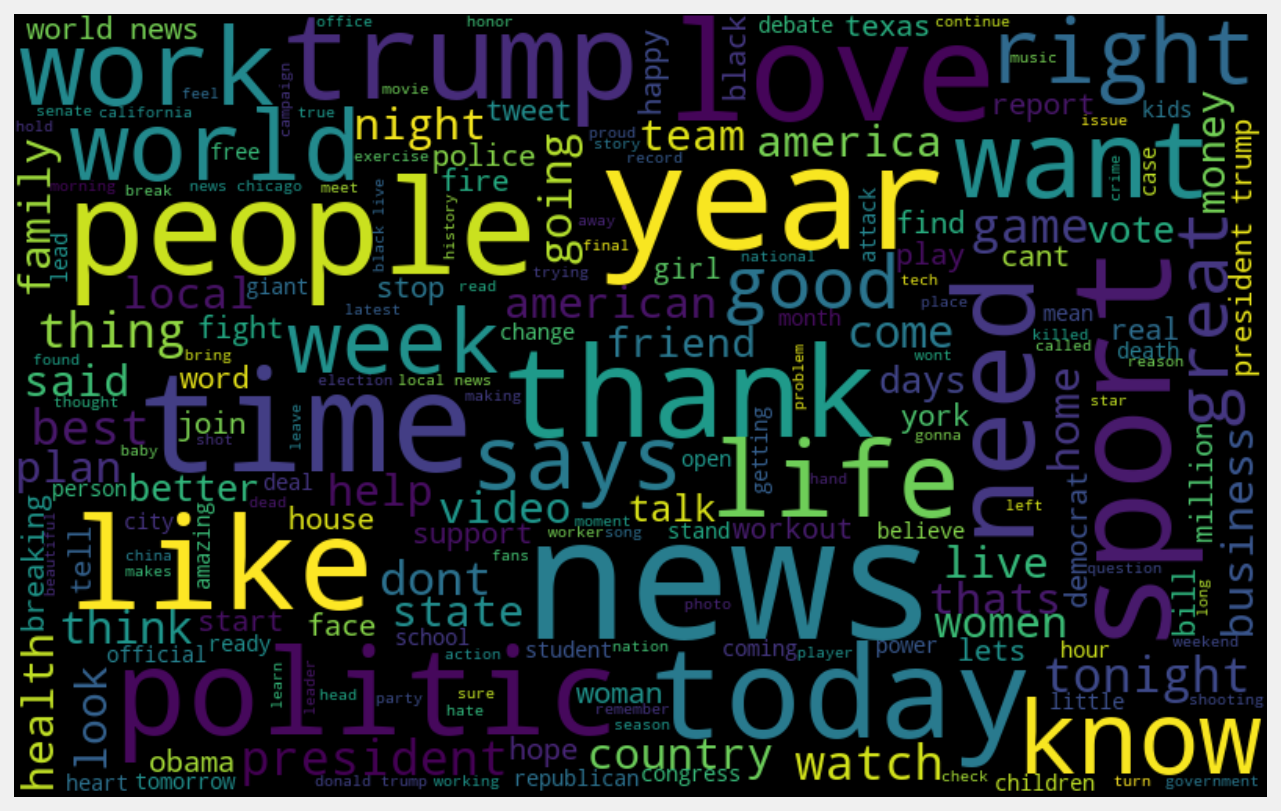

In [63]:
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [64]:
# words in verified users
verified_words = " ".join([text for text in df["clean_tweet"][df["label"] == "verified"]])

In [65]:
wordcloud = WordCloud(stopwords=spacy_stopwords, width=800, height=500, random_state=21, max_font_size=110).generate(verified_words)

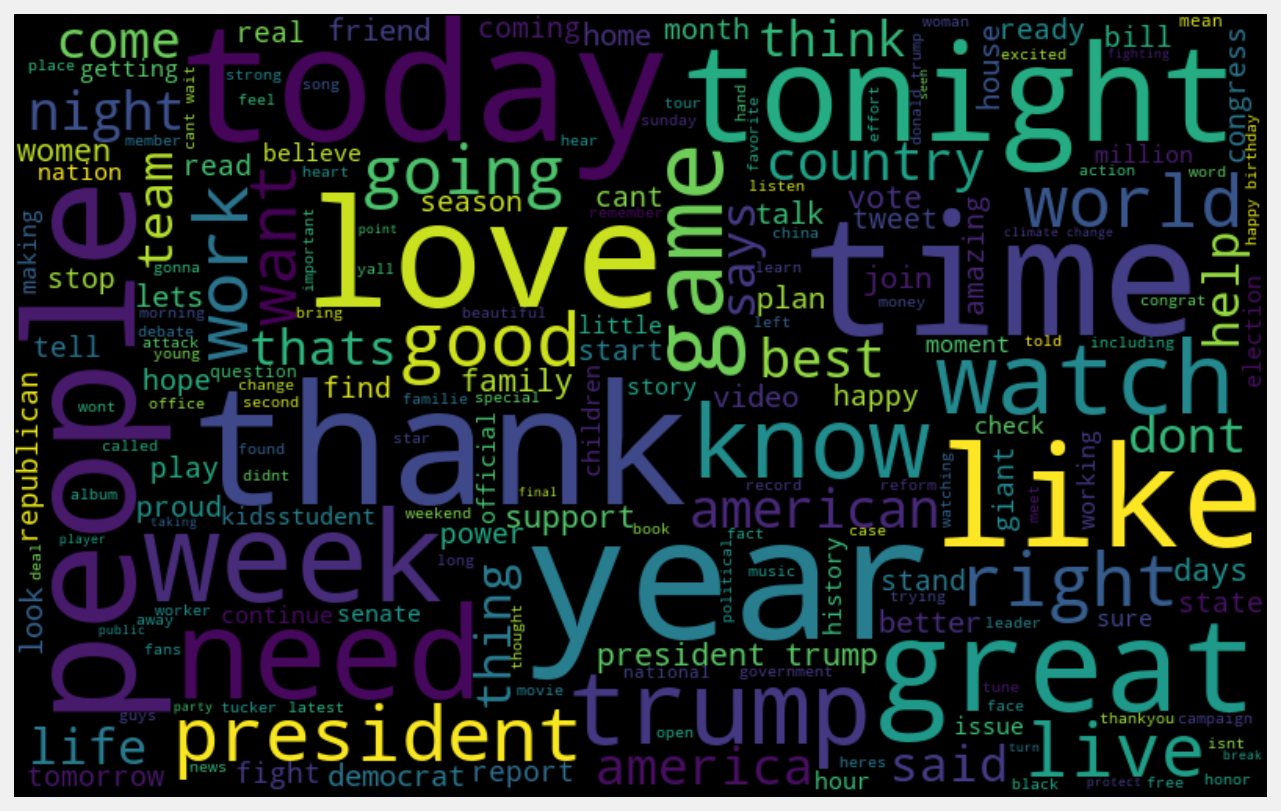

In [66]:
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

(-0.5, 799.5, 499.5, -0.5)

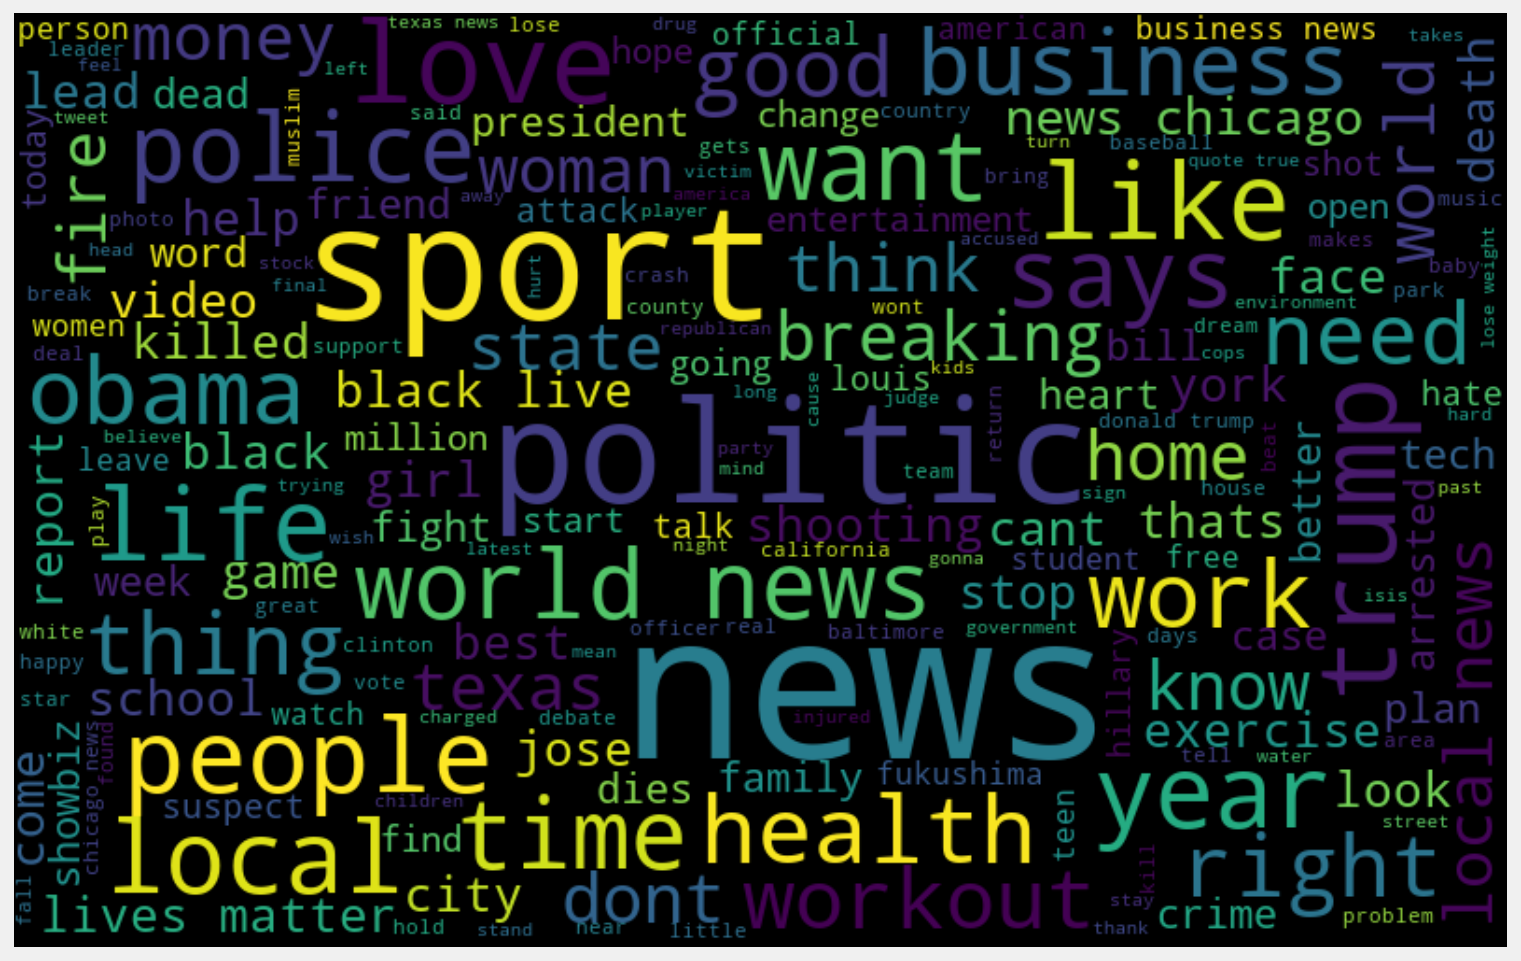

In [68]:
# words in ira tweets
ira_words = " ".join([text for text in df["clean_tweet"][df["label"] == "fake"]])

wordcloud = WordCloud(
    stopwords=spacy_stopwords,
    width=800,
    height=500,
    random_state=21,
    max_font_size=110).generate(ira_words)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

In [69]:
df[:5]

full_text  \
0  On October 16th, one supporter will get a chan...   
1  OMG I’ve been dying to tell you about the new ...   
2  The #SchumerStandard for filling #SCOTUS vacan...   
3  RT @alicia_keysbr: When someone says #TeamAlic...   
4  “Whether it is because of distance, health pro...   

                                         clean_tweet     label  
0  october supporter will chance watch debate wit...  verified  
1  been dying tell about cozy collection pajamas ...  verified  
2          schumer standard filling scotus vacancies  verified  
3  when someone says team alicia strongest alread...  verified  
4  whether because distance health problems work ...  verified

In [70]:
df["full_text"][:5].str.findall(r"#(\w+)")

0                           []
1                           []
2    [SchumerStandard, SCOTUS]
3                 [TeamAlicia]
4                           []
Name: full_text, dtype: object

In [71]:
def hashtag_extract(x):
    """
    Function to collect hashtags.
    """
    hashtags = []
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
        
    return hashtags

In [72]:
hashtags_verif = hashtag_extract(df["full_text"][df["label"] == "verified"])

In [73]:
hashtags_ira = hashtag_extract(df["full_text"][df["label"] == "fake"])

In [75]:
hashtags_verif[:3]

[[], [], ['SchumerStandard', 'SCOTUS']]

In [78]:
verif_tags = [hashtag for hashtag in hashtags_verif for hashtag in hashtag]
ira_tags = [hashtag for hashtag in hashtags_ira for hashtag in hashtag]

In [80]:
from collections import Counter

In [88]:
vtag_string = " ".join(verif_tags)
itag_string = " ".join(ira_tags)

(-0.5, 799.5, 499.5, -0.5)

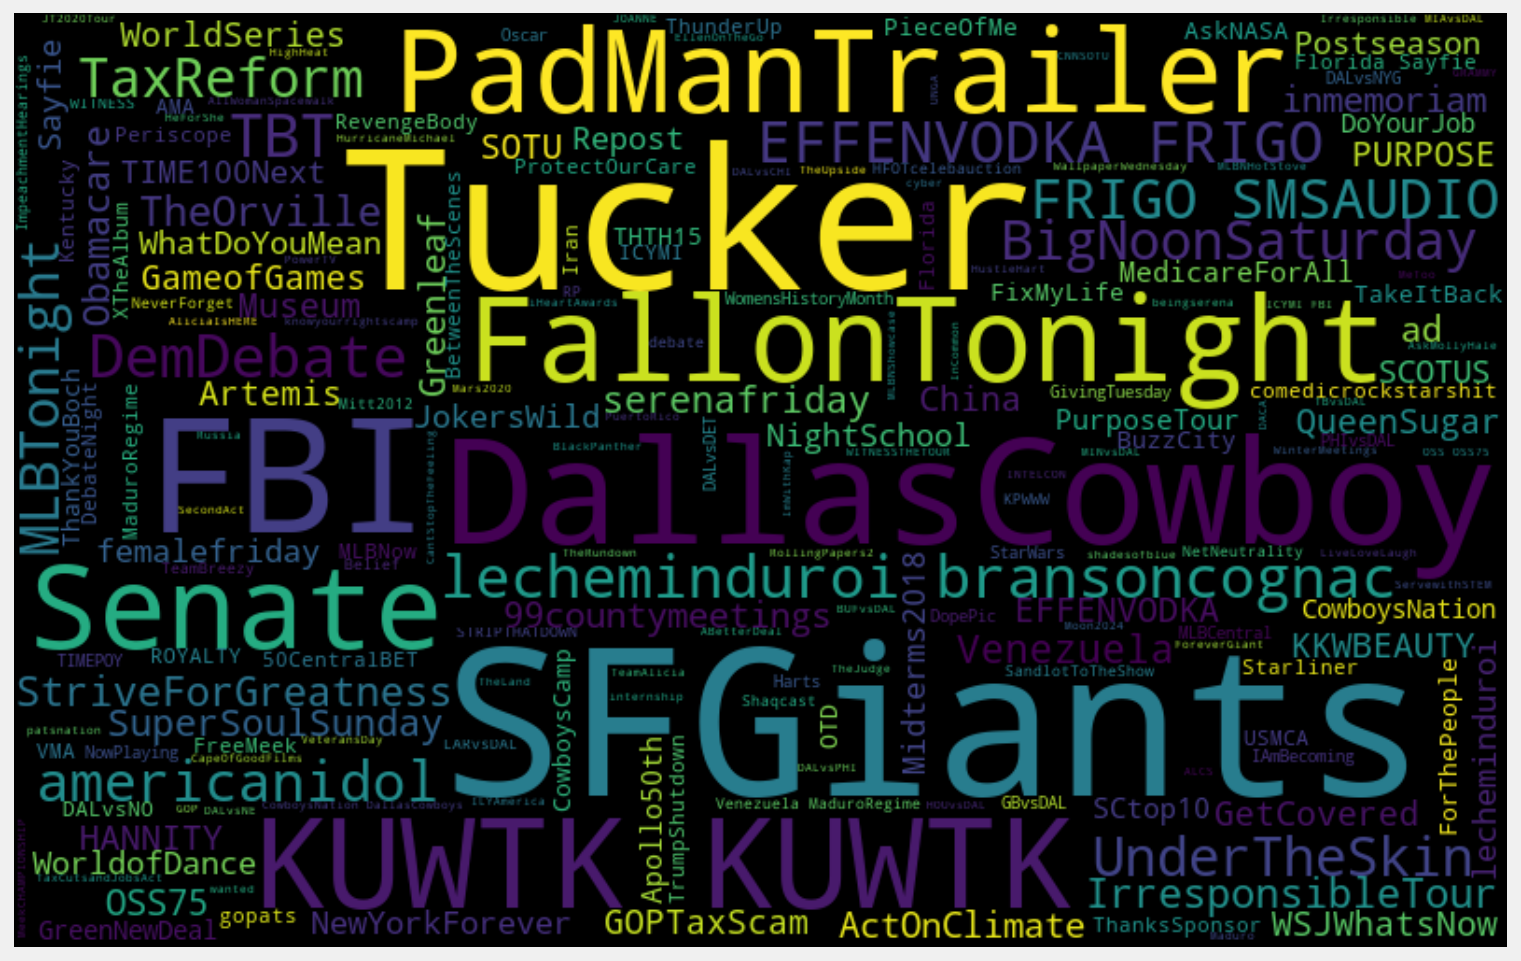

In [89]:
# wordcloud of verified tweet hashtags
wordcloud = WordCloud(
    stopwords=spacy_stopwords,
    width=800,
    height=500,
    random_state=21,
    max_font_size=110).generate(vtag_string)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

(-0.5, 799.5, 499.5, -0.5)

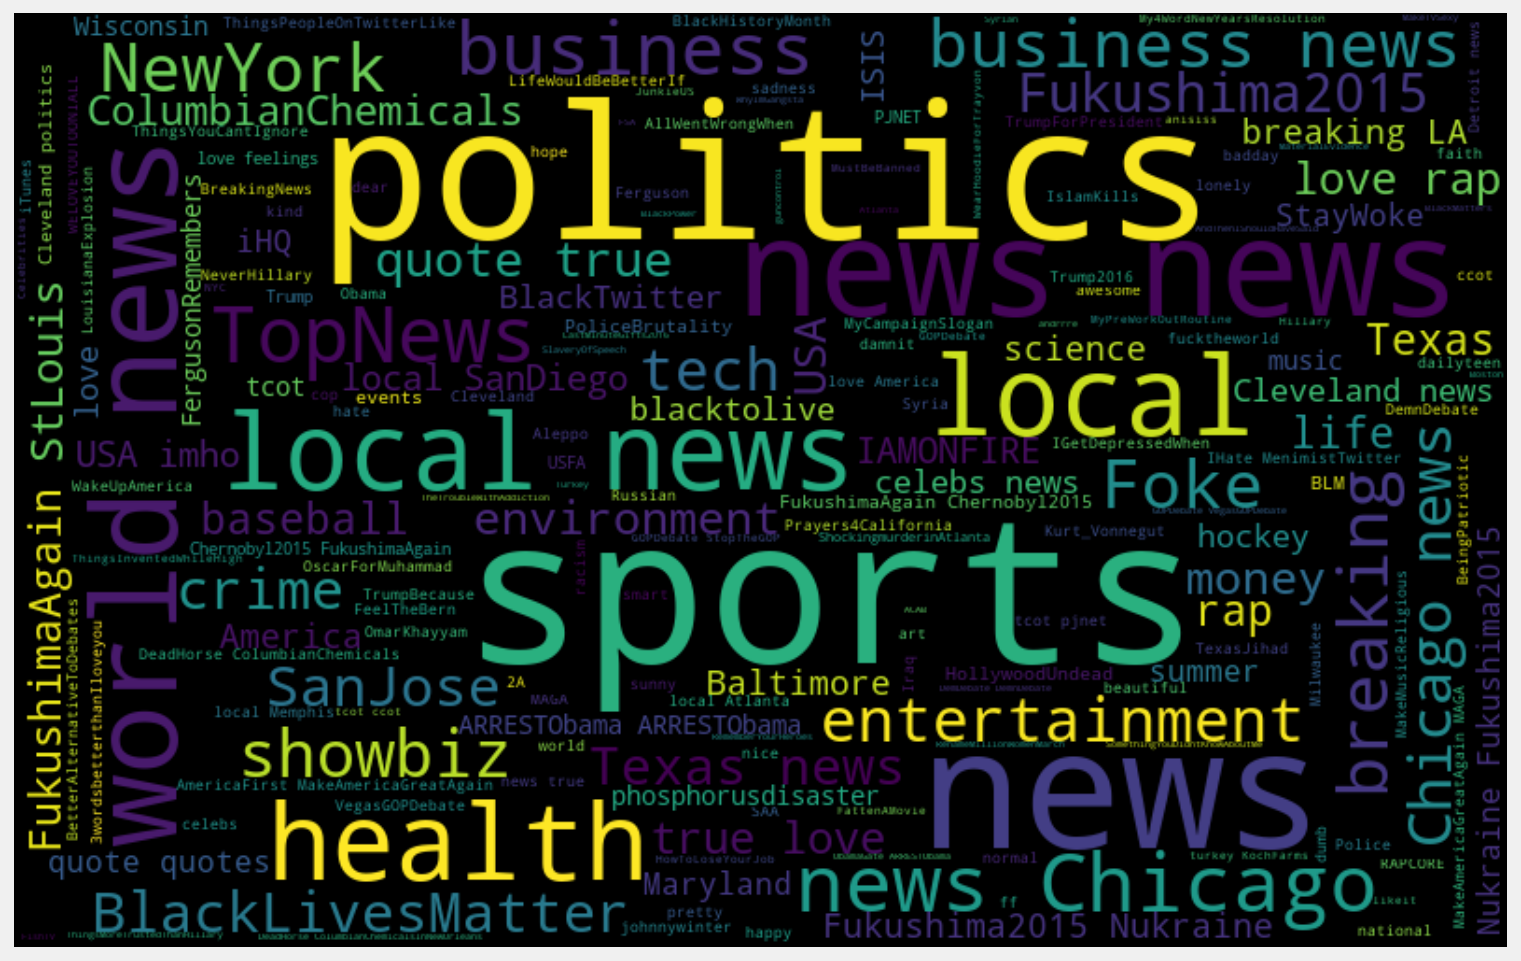

In [90]:
# wordcloud of verified tweet hashtags
wordcloud = WordCloud(
    stopwords=spacy_stopwords,
    width=800,
    height=500,
    random_state=21,
    max_font_size=110).generate(itag_string)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")